# Cointegration Example in time series

Example 3.1 from the book "Likelihood-Based-Inference-Cointegrated-Autoregressive-Econometrics"

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR
%pylab inline
pylab.rcParams['figure.figsize'] = (18.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


In [41]:
mu, sigma = 0, 1 # mean and standard deviation
n = 10000
s1 = np.random.normal(mu, sigma, n)
s2 = np.random.normal(mu, sigma, n)
s3 = np.random.normal(mu, sigma, n)

/home/ivan/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


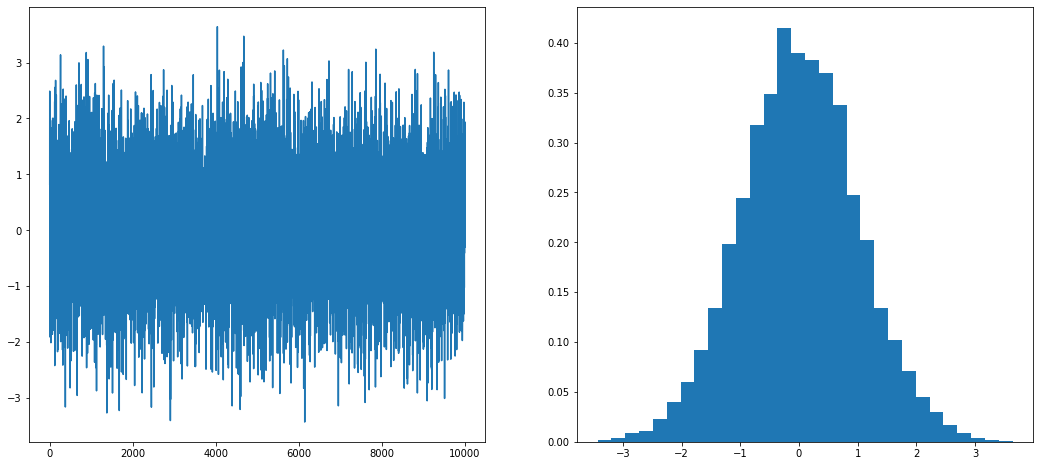

In [42]:
s = s1
plt.figure(1)
plt.subplot(121)
plt.plot(s)
plt.subplot(122)
plt.hist(s, 30, normed=True)
plt.show()

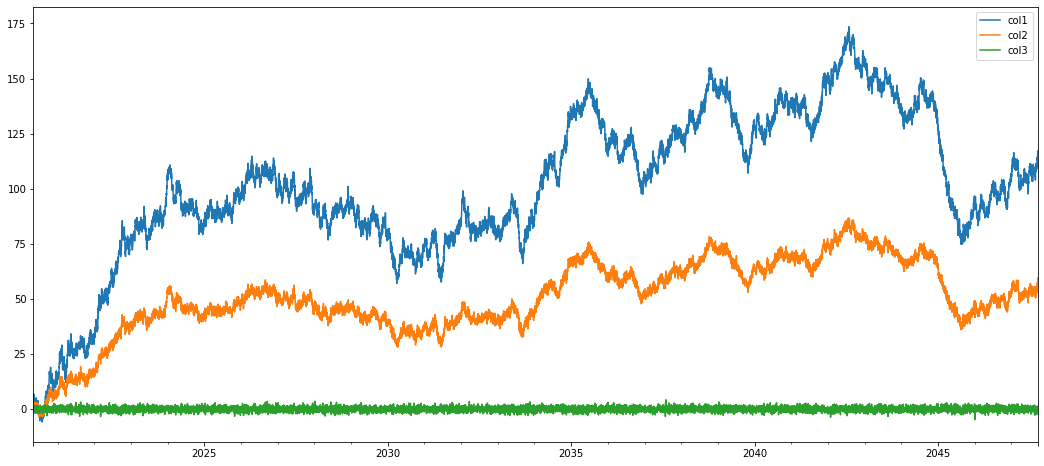

In [43]:
a = 0.5
x_1t = np.cumsum(s1)+s2
x_2t = a*np.cumsum(s1)+s3
x_3t = s3
todays_date = datetime.datetime.now().date()
index = pd.date_range(todays_date-datetime.timedelta(10), periods=n, freq='D')
y = pd.DataFrame(index=index, data={'col1': x_1t, 'col2': x_2t, 'col3':x_3t} )
y.plot()

## Augmented Dickey Fuller test

In [44]:
def ADF(v, crit='5%', max_d=6, reg='nc', autolag='AIC'):
    """ Augmented Dickey Fuller test

    Parameters
    ----------
    v: ndarray matrix
        residuals matrix

    Returns
    -------
    bool: boolean
        true if v pass the test 
    """

    boolean = False

    
    adf = adfuller(v, max_d, reg, autolag)
    print(adf)
    if(adf[0] < adf[4][crit]):
        pass
    else:
        boolean = True

    return boolean

# Testing Unit root

In [45]:
print(ADF(x_1t))   # unit root hypothesis can't be rejected
print(ADF(np.diff(x_1t)))
print(ADF(x_2t))   # unit root hypothesis can't be rejected
print(ADF(np.diff(x_2t)))
print(ADF(x_3t))   # unit root hypothesis is rejected at the 95 per cent level  -> I(0)

(0.16647127860310806, 0.7368481328348828, 4, 9995, {'1%': -2.5659637281522203, '5%': -1.9410269070891237, '10%': -1.616793453855115}, 37942.11103887381)
True
(-59.32807527474657, 0.0, 3, 9995, {'1%': -2.5659637281522203, '5%': -1.9410269070891237, '10%': -1.616793453855115}, 37937.05379019144)
False
(0.13724497882967246, 0.7280312137050579, 6, 9993, {'1%': -2.5659637729364624, '5%': -1.9410269124810415, '10%': -1.616793448547595}, 33222.48857535285)
True
(-48.801075370822325, 0.0, 6, 9992, {'1%': -2.5659637953353074, '5%': -1.9410269151778108, '10%': -1.616793445893039}, 33217.68384962839)
False
(-56.35995820102735, 0.0, 2, 9997, {'1%': -2.5659636833859, '5%': -1.9410269016993662, '10%': -1.6167934591605133}, 28607.27660224007)
False


## Johansen function

In [46]:
def get_johansen(y, p):
        """
        Get the cointegration vectors at 95% level of significance
        given by the trace statistic test.
        """

        N, l = y.shape
        jres = coint_johansen(y, 0, p)
        trstat = jres.lr1                       # trace statistic
        tsignf = jres.cvt                       # critical values

        for i in range(l):
            if trstat[i] > tsignf[i, 1]:     # 0: 90%  1:95% 2: 99%
                r = i + 1
        jres.r = r
        jres.evecr = jres.evec[:, :r]

        return jres

In [47]:
p=1
jres=get_johansen(y,p)
print(f'There are {jres.r}cointegration vectors')
v1=jres.evecr[:,0]
v2=jres.evecr[:,1]
v3=jres.evec[:,2]  # v3 is not a cointegration vector
print(v1)
print(v2)
print(v3)


There are 3cointegration vectors
[-0.92661085  1.8531941  -0.78607497]
[ 1.08508196 -2.16956694  3.07293763]
[ 1.15387388e-05  5.96087577e-02 -5.72758208e-02]


Even though we were expecting [0.5 -1 0] y [0 0 1] these vectors are in the same vector space. If we divide every vector by their second component we will get some similar results.

In [48]:
v1/-v1[1]

array([ 0.50000745, -1.        ,  0.42417304])

In [49]:
v2/-v2[1]

array([ 0.50013758, -1.        ,  1.41638295])

In [50]:
v3/-v3[1]

array([-1.93574556e-04, -1.00000000e+00,  9.60862514e-01])

/home/ivan/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


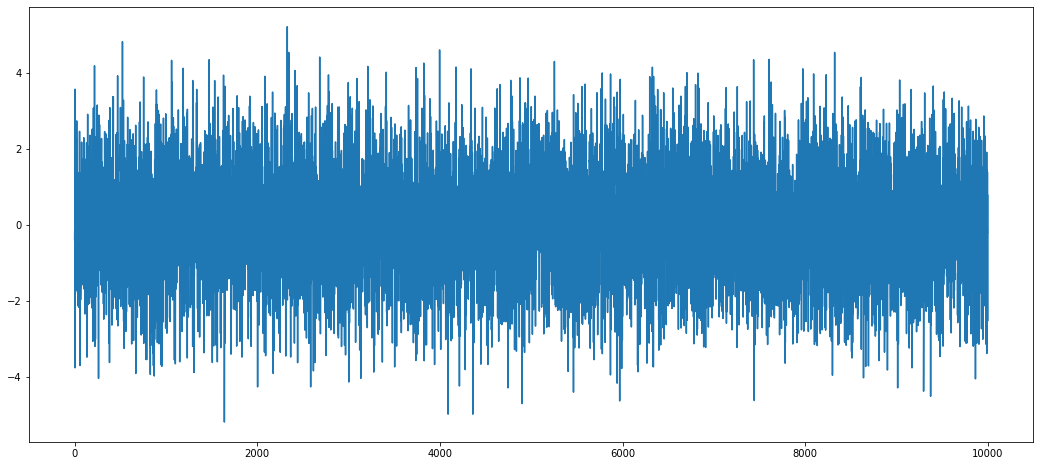

In [51]:
# If we apply vector v1 we get a I(0) time series
plot(np.dot(y.as_matrix(),v1))

/home/ivan/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


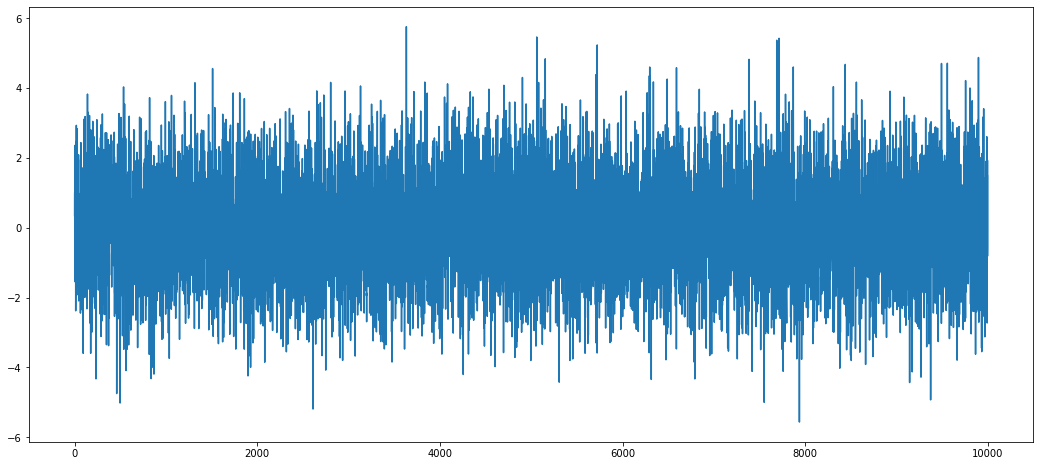

In [52]:
# If we apply vector v2 we get a I(0) time series
plot(np.dot(y.as_matrix(),v2))

/home/ivan/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


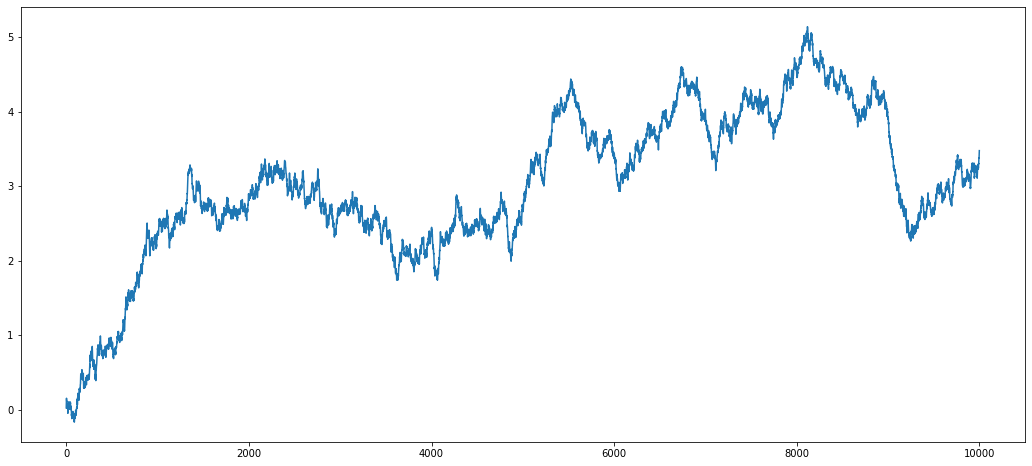

In [53]:
# If we apply vector v3 we won't get a I(0) time series since it's not a cointegration vector.
plot(np.dot(y.as_matrix(),v3))